In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from datetime import date
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, normalize
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline
pd.set_option('mode.chained_assignment', None)

In [2]:
DATASET_PATH = '../data/GEDEvent_v23_1.csv'
DATE_FMT_STRING = '%Y-%m-%d %X.000'
USE_FEATURES = ['id', 'year', 'type_of_violence', 'where_coordinates', 'country', 'country_id', 'region', 'date_start', 'date_end', 'best']
TS_FEATURES = ['best_t1', 'best_t2', 'best_t3', 'count_t1', 'count_t2', 'count_t3']
TRAIN_YEAR = '1989'
VAL_YEAR = '2008'
TEST_YEAR = '2016'

In [3]:
data = pd.read_csv(DATASET_PATH, low_memory=False)

In [4]:
print(data.shape)

(316818, 49)


In [5]:
print(data.columns)

Index(['id', 'relid', 'year', 'active_year', 'code_status', 'type_of_violence',
       'conflict_dset_id', 'conflict_new_id', 'conflict_name', 'dyad_dset_id',
       'dyad_new_id', 'dyad_name', 'side_a_dset_id', 'side_a_new_id', 'side_a',
       'side_b_dset_id', 'side_b_new_id', 'side_b', 'number_of_sources',
       'source_article', 'source_office', 'source_date', 'source_headline',
       'source_original', 'where_prec', 'where_coordinates',
       'where_description', 'adm_1', 'adm_2', 'latitude', 'longitude',
       'geom_wkt', 'priogrid_gid', 'country', 'country_id', 'region',
       'event_clarity', 'date_prec', 'date_start', 'date_end', 'deaths_a',
       'deaths_b', 'deaths_civilians', 'deaths_unknown', 'best', 'high', 'low',
       'gwnoa', 'gwnob'],
      dtype='object')


To prepare for time series forecasting, place the data into buckets based on which half-month they are in. Before that, let's narrow down the subset of the dataset that we want to use.

In [6]:
def parse_row_date(date: str) -> datetime:
    try:
        parsed_date_obj = datetime.strptime(date, DATE_FMT_STRING)
        return parsed_date_obj
    except ValueError:
        print('Error converting row date to datetime object: %s', date)
        return None

# print(parse_row_date(data['date_start'][0]))

def get_period_id(date_obj: datetime, country_id: int) -> str:
    year = date_obj.year
    month = date_obj.month
    bimonthly_period = 0 if date_obj.day <= 15 else 1
    return str(year) + '_' + str(month) + '_' + str(bimonthly_period) + '_' + str(country_id)

def add_row_to_period(row, period_features):
    if row['region'] != 'Middle East' and row['country'] not in ['India', 'Afghanistan']:
        return
    
    period_id = get_period_id(parse_row_date(row['date_start']), row['country'])
    
    try:
        t = str(row['type_of_violence'])
        period_features[period_id]['count_t' + t] += 1
        period_features[period_id]['best_t' + t] += row['best']
    except KeyError:
        print('Key ' + period_id + ' not found in period_features dictionary when attempting to add row.')

In [7]:
period_features = {}

COUNTRIES = data.loc[(data['region'] == 'Middle East') | (data['country'] == 'India') | (data['country'] == 'Afghanistan'), :]['country'].unique()
for country in COUNTRIES:
    for year in range(1989, 2023):
        for month in range(1, 13):
            for period in range(0, 2):
                period_id = get_period_id(date(year, month, period * 15 + 1), country)
                # print(period_id)
                if period_features.get(period_id) == None:
                    period_features[period_id] = {}
                    period_features[period_id]['country'] = country
                    for feature in TS_FEATURES:
                        period_features[period_id][feature] = 0 

In [8]:
data.apply(lambda row: add_row_to_period(row, period_features), axis = 1)

0         None
1         None
2         None
3         None
4         None
          ... 
316813    None
316814    None
316815    None
316816    None
316817    None
Length: 316818, dtype: object

In [9]:
time_series_data = pd.DataFrame.from_dict(period_features, orient='index')
time_series_data.reset_index(inplace=True)
time_series_data

,index,country,best_t1,best_t2,best_t3,count_t1,count_t2,count_t3
0,1989_1_0_Afghanistan,Afghanistan,39,0,0,5,0,0
1,1989_1_1_Afghanistan,Afghanistan,675,0,0,8,0,0
2,1989_2_0_Afghanistan,Afghanistan,48,0,0,6,0,0
3,1989_2_1_Afghanistan,Afghanistan,112,0,0,10,0,0
4,1989_3_0_Afghanistan,Afghanistan,1424,0,0,13,0,0
...,...,...,...,...,...,...,...,...
13051,2022_10_1_Yemen (North Yemen),Yemen (North Yemen),30,10,1,17,3,1
13052,2022_11_0_Yemen (North Yemen),Yemen (North Yemen),26,4,0,12,1,0
13053,2022_11_1_Yemen (North Yemen),Yemen (North Yemen),24,15,0,10,6,0
13054,2022_12_0_Yemen (North Yemen),Yemen (North Yemen),22,1,2,6,1,1


In [10]:
def train_test_split(ds: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    # print(ds['index'].str[:4])
    train = ds.loc[ds['index'].str[:4] < VAL_YEAR, :]
    val = ds.loc[(ds['index'].str[:4] >= VAL_YEAR) & (ds['index'].str[:4] < TEST_YEAR), :]
    test = ds.loc[ds['index'].str[:4] >= TEST_YEAR, :]
    
    return (train, val, test)

def stdize(train, val, test):
    scaler = StandardScaler()
    cols = train.select_dtypes(include=np.number).columns.tolist()
    # print(cols)
    scaler.fit(train[cols])
    
    ds_list = [train, val, test]
    for index, _ in enumerate(ds_list):
        ds_list[index].loc[:, cols] = scaler.transform(ds_list[index][cols])
    
    return scaler

def lag_x(time_series_data: pd.DataFrame, col: str, x: int):
    time_series_data.loc[:, col + '_lag' + str(x)] = time_series_data.loc[:, col].shift(x).fillna(0).astype('int32')
    
def rolling_max_x(time_series_data: pd.DataFrame, col:str, x: int):
    time_series_data.loc[:, col + '_rmax' + str(x)] = time_series_data.loc[:, col].rolling(x).max().fillna(0).astype('int32')

Now that we have a working time-series dataset, we can use feature engineering to extract meaningful features from the data.

In [11]:
train, val, test = train_test_split(time_series_data)

ds_list = [train, val, test]
for index, _ in enumerate(ds_list):
    ds_list[index].drop(columns='index', inplace=True)
    ds_list[index].reset_index(inplace=True, drop=True)
    
train

,country,best_t1,best_t2,best_t3,count_t1,count_t2,count_t3
0,Afghanistan,39,0,0,5,0,0
1,Afghanistan,675,0,0,8,0,0
2,Afghanistan,48,0,0,6,0,0
3,Afghanistan,112,0,0,10,0,0
4,Afghanistan,1424,0,0,13,0,0
...,...,...,...,...,...,...,...
7291,Yemen (North Yemen),0,0,0,0,0,0
7292,Yemen (North Yemen),0,0,0,0,0,0
7293,Yemen (North Yemen),0,0,0,0,0,0
7294,Yemen (North Yemen),0,0,0,0,0,0


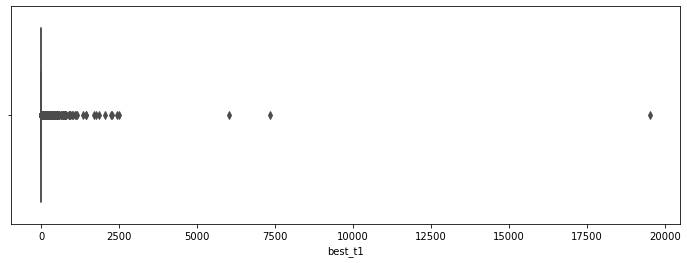

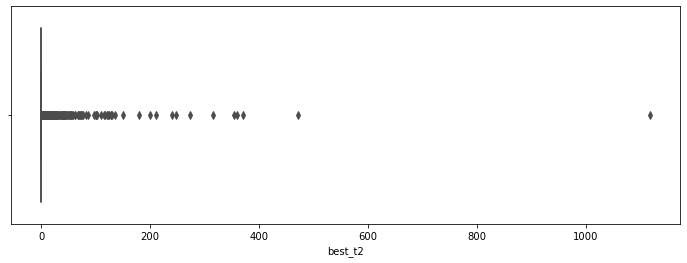

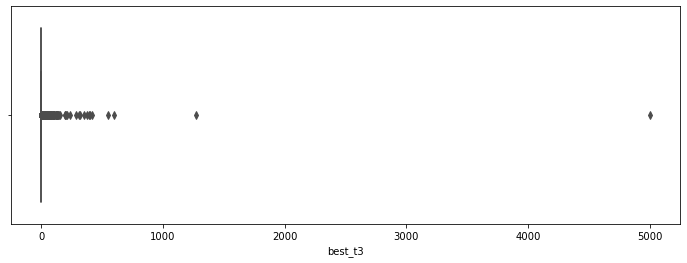

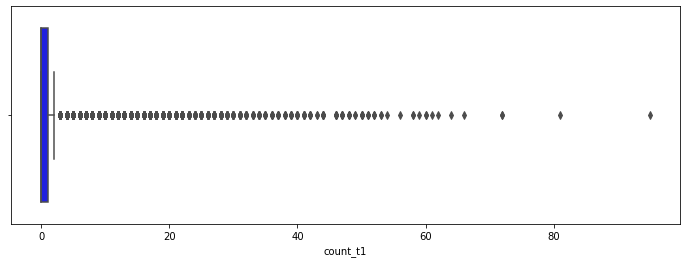

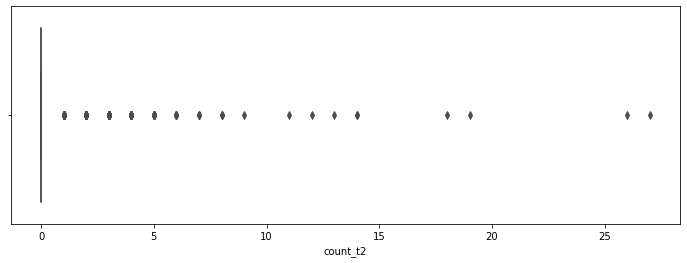

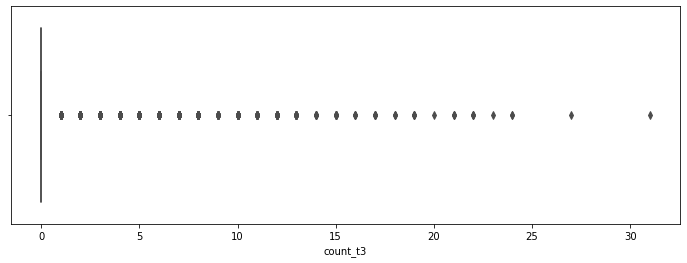

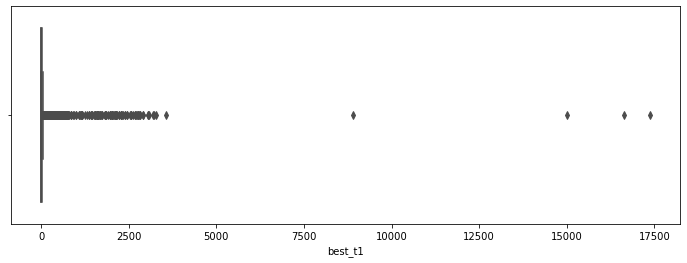

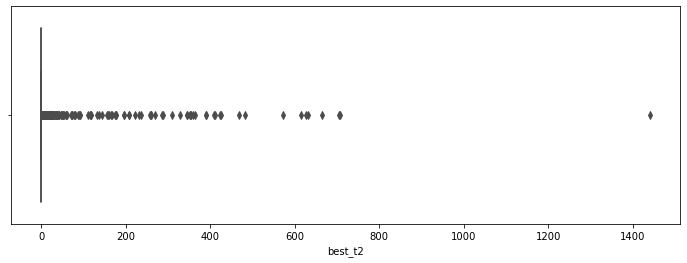

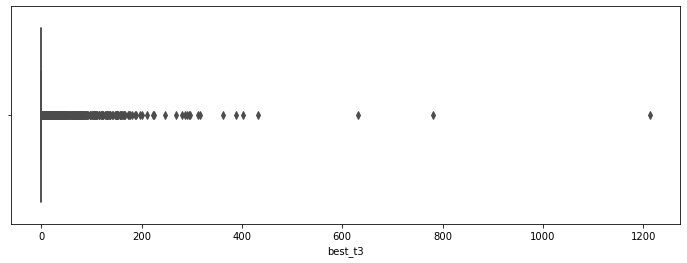

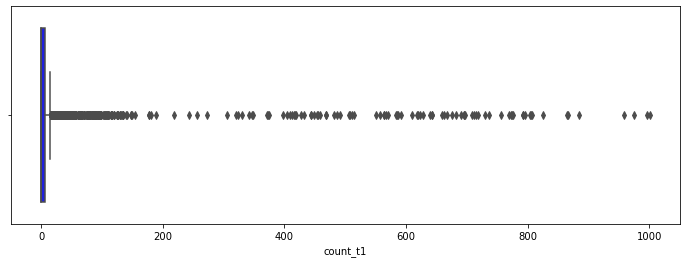

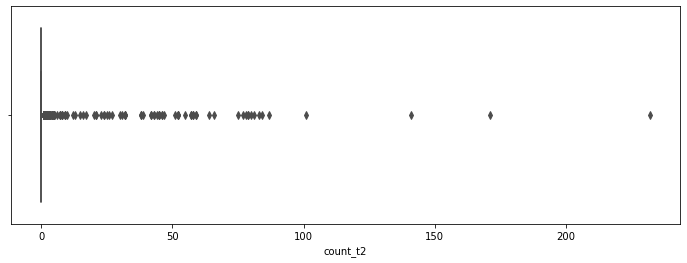

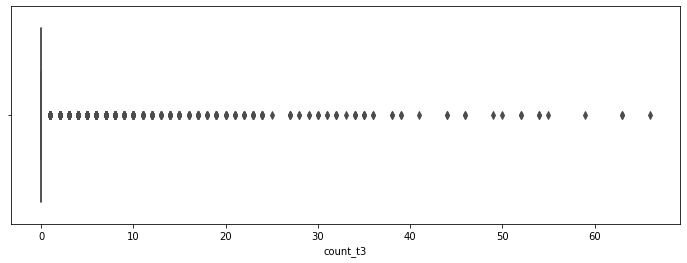

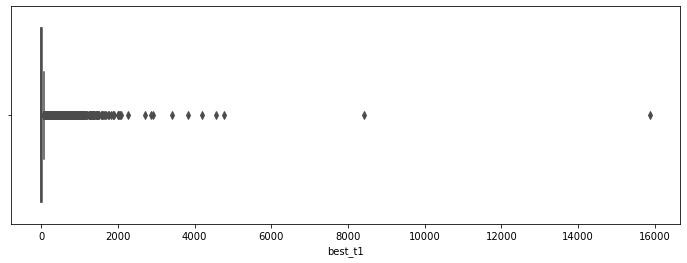

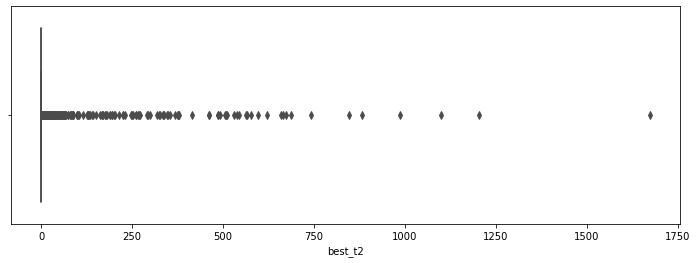

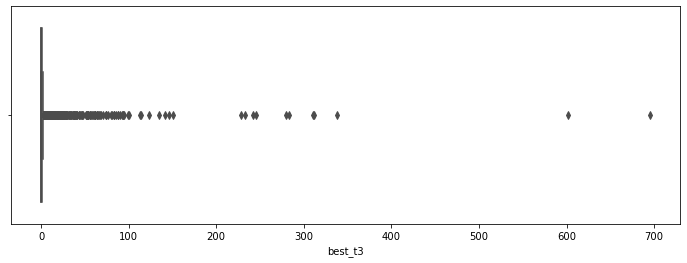

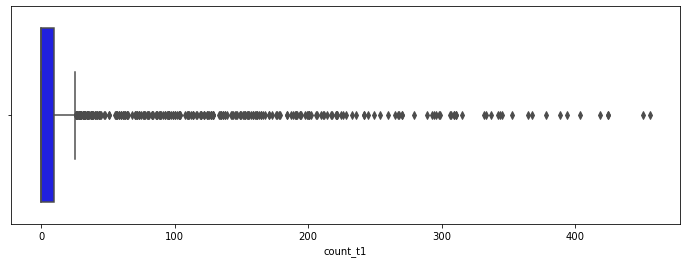

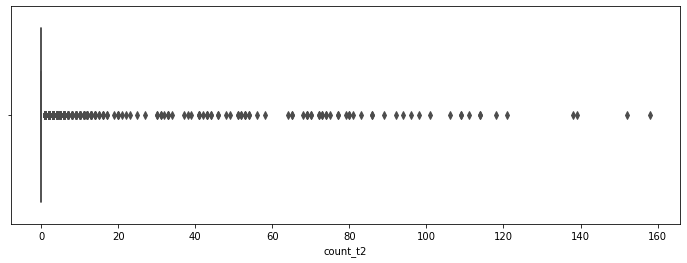

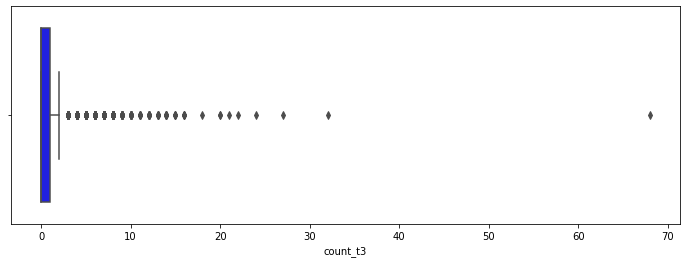

In [12]:
def boxplot_features(ds):
    for i in TS_FEATURES:
        plt.figure(figsize=(12, 4))
        sns.boxplot(x=ds[i], color='blue')
    
for ds in [train, val, test]:
    boxplot_features(ds)

(array([6.16e+03, 3.02e+02, 2.04e+02, 1.48e+02, 8.70e+01, 6.70e+01,
        5.70e+01, 4.20e+01, 3.10e+01, 2.20e+01, 2.20e+01, 1.40e+01,
        1.40e+01, 1.30e+01, 6.00e+00, 7.00e+00, 9.00e+00, 7.00e+00,
        8.00e+00, 7.00e+00, 4.00e+00, 2.00e+00, 1.00e+00, 7.00e+00,
        1.00e+00, 3.00e+00, 3.00e+00, 2.00e+00, 2.00e+00, 2.00e+00,
        0.00e+00, 3.00e+00, 0.00e+00, 1.00e+00, 3.00e+00, 2.00e+00,
        2.00e+00, 1.00e+00, 2.00e+00, 2.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 2.00e+00, 1.00e+00, 3.00e+00, 1.00e+00,
        0.00e+00, 1.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00,
        1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 

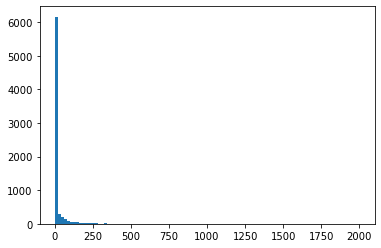

In [13]:
plt.figure()
plt.hist(train['best_t1'], bins=100, range=(0, 2000))

Now, we can make some baseline models.

In [14]:
def zero(series):
    return pd.Series([0] * series.shape[0])

def last(series):
    return series.shift(1).fillna(0)

def fixed_moving_average(series, window_size=9):
    return series.shift(1).rolling(window_size).mean().fillna(0)

In [15]:
baselines = [zero, last, fixed_moving_average]

#evaluate for Afghanistan
test_ = test[test['country'] == 'Afghanistan']
for bl in baselines:
    preds = bl(test_['best_t1'])
    mse = mean_squared_error(test_['best_t1'], preds)
    # mae = mean_absolute_error(test_['best_t1'], preds)
    print('MSE for baseline for function ' + bl.__name__ + ': ' + str(mse))

MSE for baseline for function zero: 1392579.5416666667
MSE for baseline for function last: 253813.25595238095
MSE for baseline for function fixed_moving_average: 527513.9007936508


In [16]:
#check for stationarity
from statsmodels.tsa.stattools import adfuller

series = pd.concat([ds[ds['country'] == 'Afghanistan']['best_t1'] for ds in [train, val, test]], ignore_index=True)

adf_result = adfuller(series)
print('p-value: ' + str(adf_result[1]))

p-value: 1.0025290559088265e-09


<AxesSubplot:>

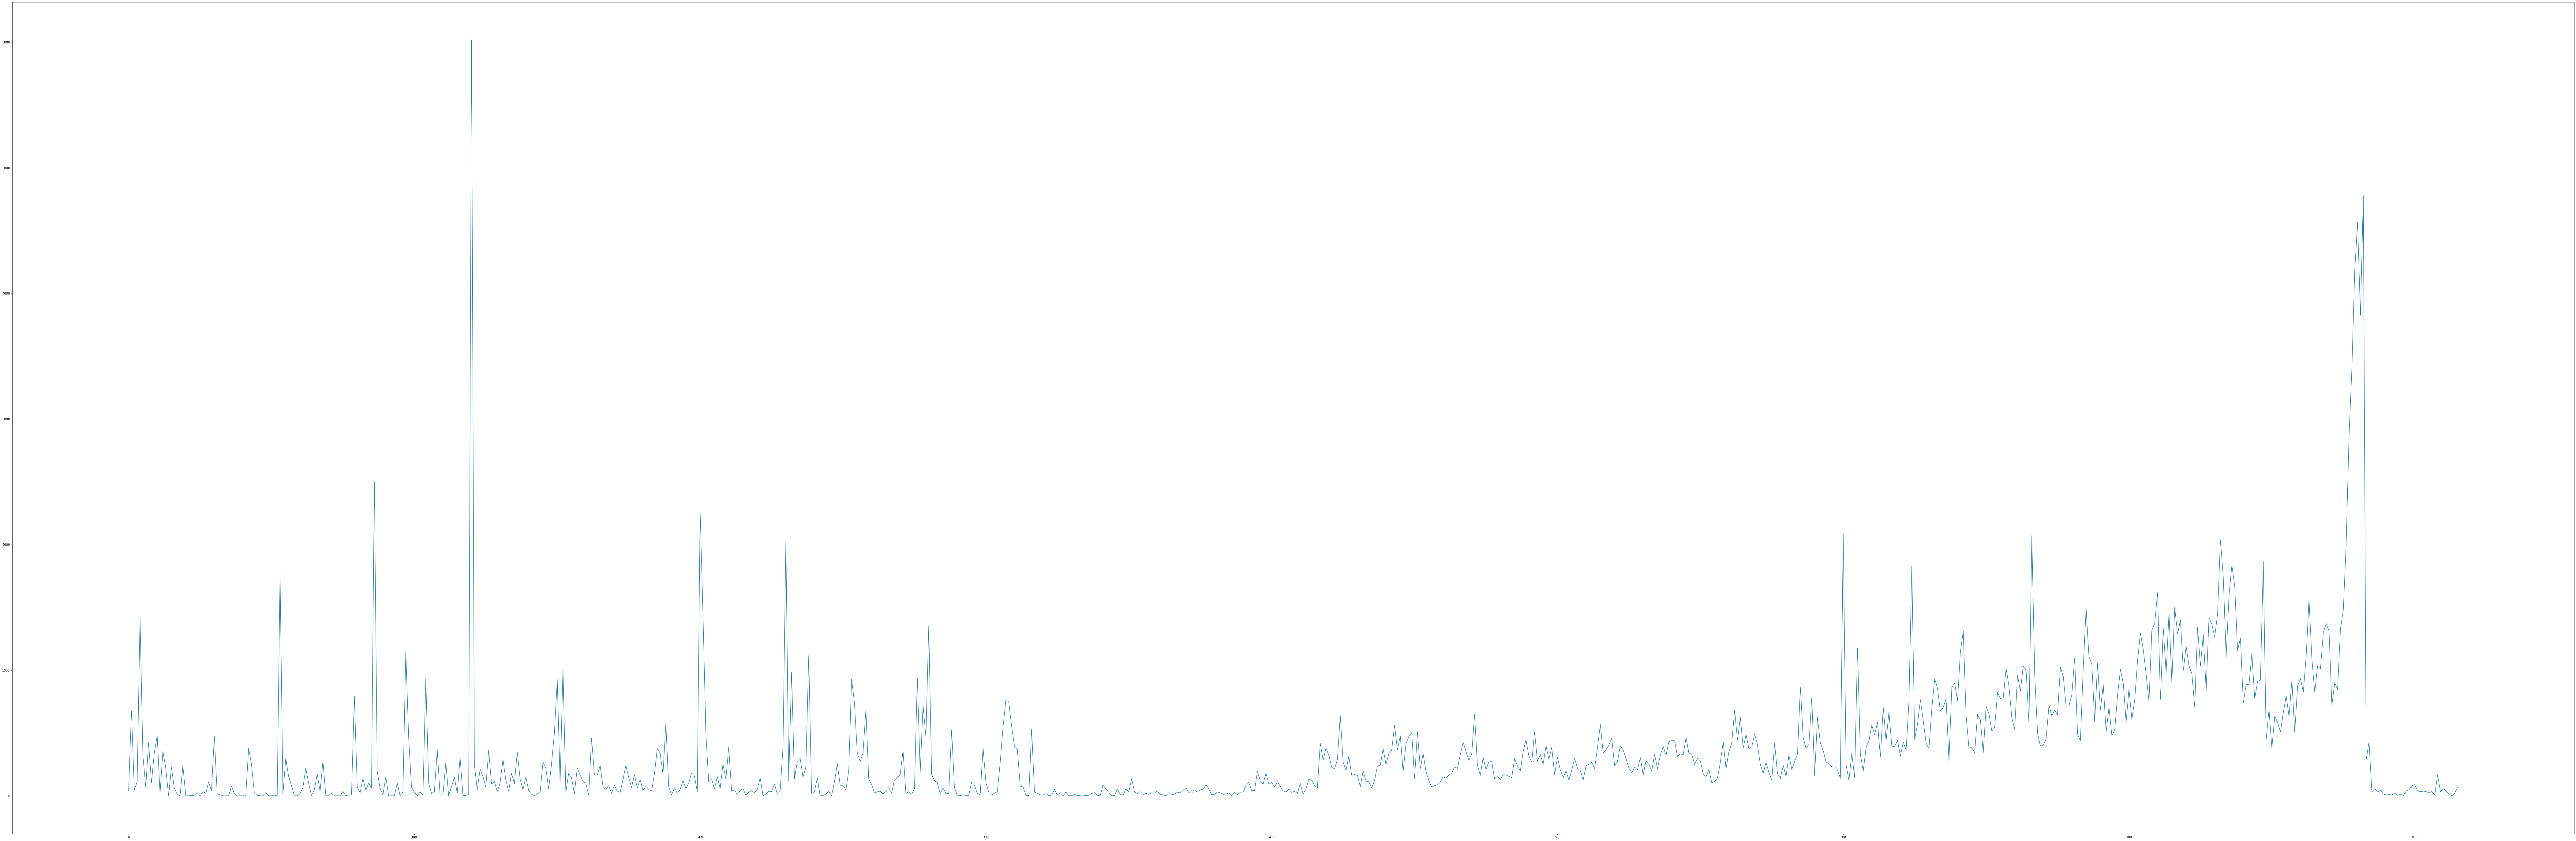

In [17]:
plt.figure(figsize=(150, 50))
sns.lineplot(y=series.values, x=series.index)

0        39
1       675
2        48
3       112
4      1424
       ... 
811      38
812      15
813       0
814      22
815      71
Name: best_t1, Length: 816, dtype: int64


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


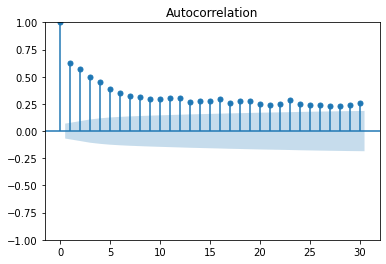

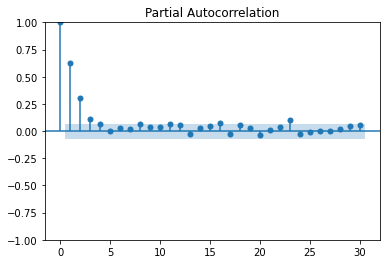

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(series)
plot_pacf(series)
print(series)

Autocorrelation tails off, so does partial autocorrelation -> use ARMA model.

In [19]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

#predictions only on Afghanistan
afgh_train = train[train['country'] == 'Afghanistan']
afgh_val = val[val['country'] == 'Afghanistan']
afgh_test = test[test['country'] == 'Afghanistan']

afgh_train.drop(columns='country', inplace=True, errors='ignore')
afgh_test.drop(columns='country', inplace=True, errors='ignore')
afgh_val.drop(columns='country', inplace=True, errors='ignore')

In [20]:
for ds in [afgh_train, afgh_val, afgh_test]:
    for feature in TS_FEATURES:
        for dt in range(1, 7):
            lag_x(ds, feature, dt)
        for dt in range(2, 7):
            rolling_max_x(ds,feature, dt)
        for col in ['count_t1', 'count_t2', 'count_t3']:
            ds.loc[:, 'dummy_' + col] = (ds[col] > 0).astype('int32')
print(afgh_train['dummy_count_t1'], afgh_train['count_t1'], afgh_train['best_t1'])

0      1
1      1
2      1
3      1
4      1
      ..
451    1
452    1
453    1
454    1
455    1
Name: dummy_count_t1, Length: 456, dtype: int32 0       5
1       8
2       6
3      10
4      13
       ..
451    51
452    39
453    41
454    27
455    26
Name: count_t1, Length: 456, dtype: int64 0        39
1       675
2        48
3       112
4      1424
       ... 
451     511
452     217
453     335
454     193
455     122
Name: best_t1, Length: 456, dtype: int64


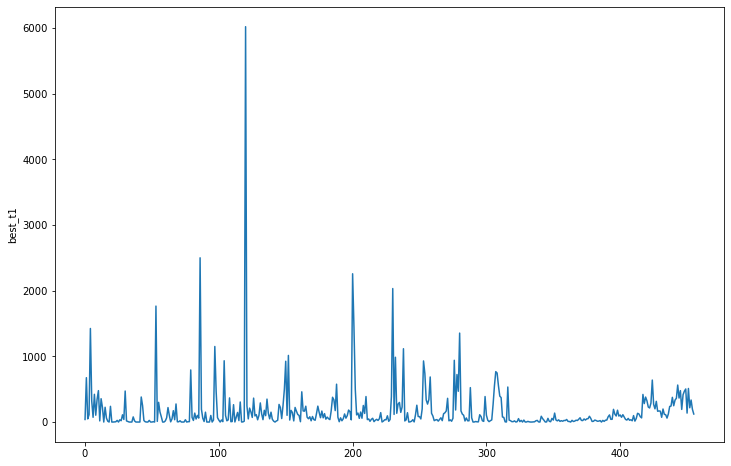

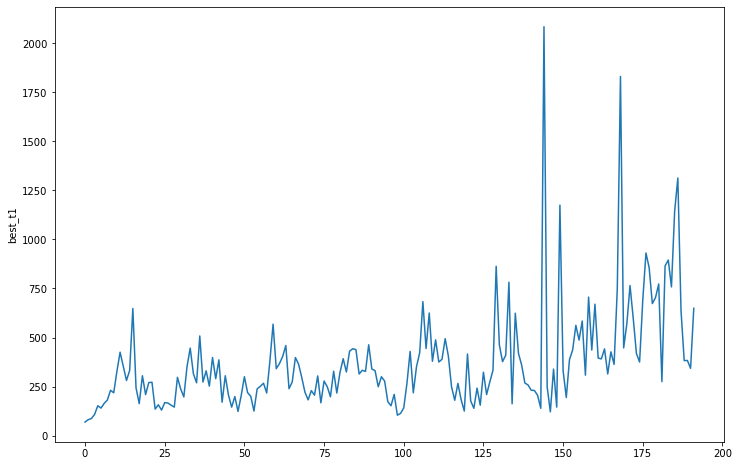

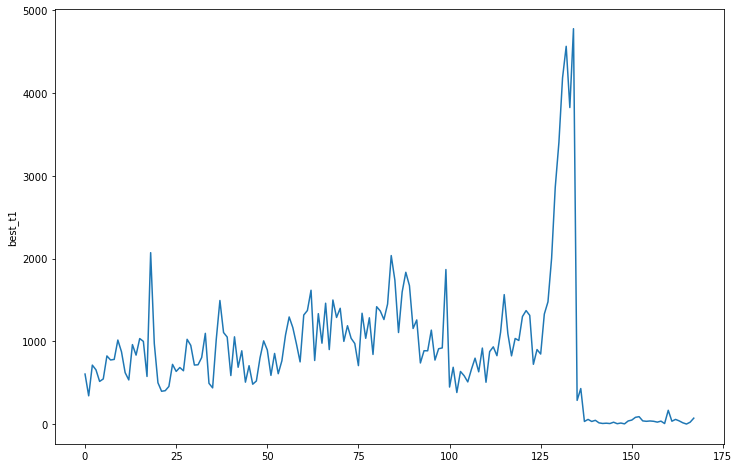

In [21]:
for ds in [afgh_train, afgh_val, afgh_test]:
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=ds, x=ds.index, y='best_t1')
    # boxplot_features(ds)

In [22]:
# fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16,8))
# res = seasonal_decompose(afgh_data['best_t1'].diff().fillna(0), period=24, model='additive', extrapolate_trend='freq')

# ax[0].set_title('Decomposition of best_t1', fontsize=16)
# res.observed.plot(ax=ax[0], legend=False, color='dodgerblue')
# ax[0].set_ylabel('Observed', fontsize=14)
# res.trend.plot(ax=ax[1], legend=False, color='dodgerblue')
# ax[1].set_ylabel('Trend', fontsize=14)
# res.seasonal.plot(ax=ax[2], legend=False, color='dodgerblue')
# ax[2].set_ylabel('Seasonal', fontsize=14)
# res.resid.plot(ax=ax[3], legend=False, color='dodgerblue')
# ax[3].set_ylabel('Residual', fontsize=14)

In [23]:
# print(afgh_train)
raw_val_y = afgh_val['best_t1']

scaler = stdize(afgh_train, afgh_val, afgh_test)

#concat series in order to perform time series split on [train, val]
# print(series_)

afgh_data = pd.concat([afgh_train, afgh_val, afgh_test], ignore_index=True)
start_val = afgh_train.shape[0]
end_val = start_val + afgh_val.shape[0]

                               SARIMAX Results                                
Dep. Variable:                best_t1   No. Observations:                  456
Model:                 ARIMA(3, 0, 3)   Log Likelihood                  87.592
Date:                Fri, 11 Aug 2023   AIC                            -11.185
Time:                        12:47:04   BIC                            326.860
Sample:                             0   HQIC                           121.978
                                - 456                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.221e-05      0.028     -0.001      0.999      -0.056       0.056
best_t2           -0.0049      0.112     -0.044      0.965      -0.224       0.214
best_t3            0.5172      3.257

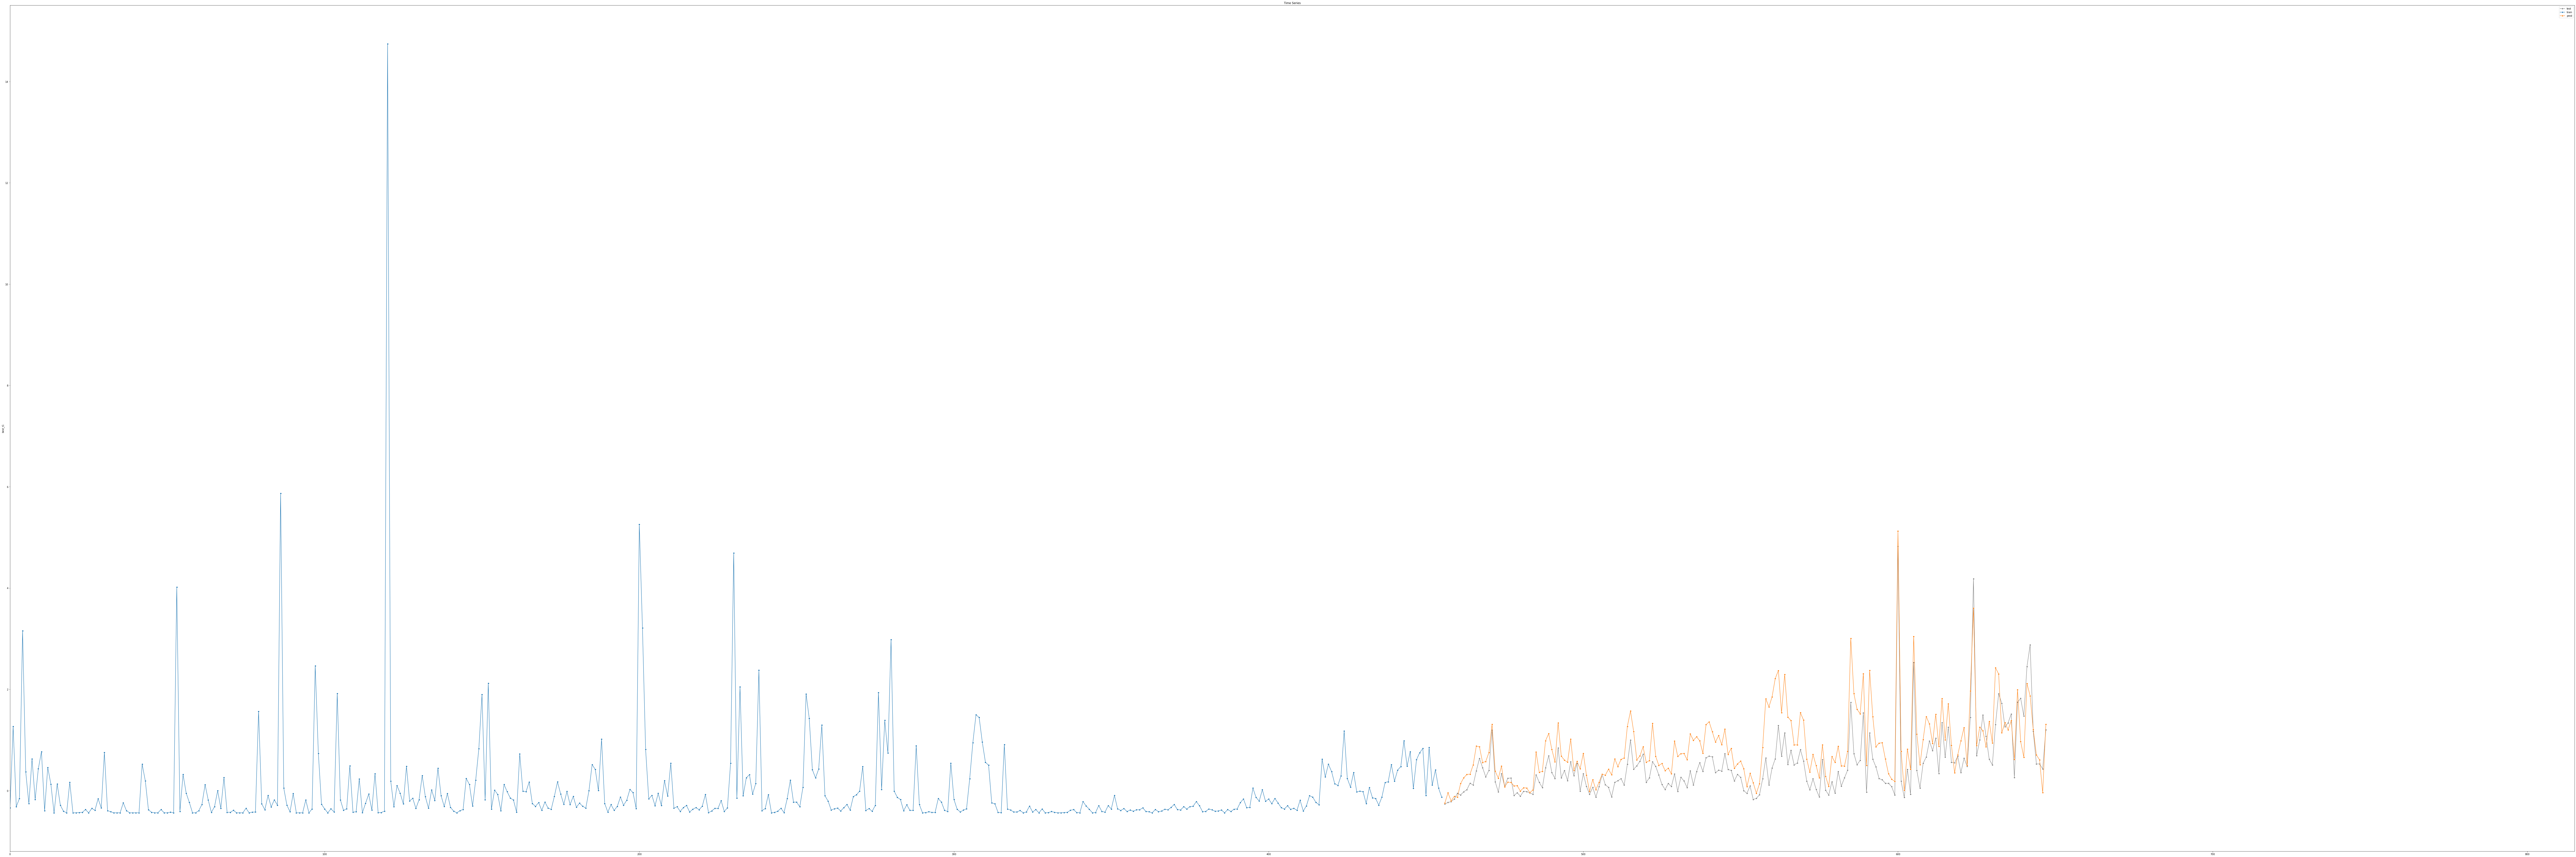

MSE unscaled on val set: 0.27350775083682627
MSE on val set: 42972.55508504306
MAE unscaled on val set: 0.4247368617711868
MAE on val set: 168.3568235969517


In [24]:
model = ARIMA(afgh_train.loc[:, 'best_t1'], exog=afgh_train.select_dtypes(include=np.number).drop(columns='best_t1'), order=(3, 0, 3)).fit(method='innovations_mle', gls_kwargs={'max_iter': 150})
print(model.summary())

pred = model.predict(start=start_val, end=end_val - 1, exog=afgh_val.select_dtypes(include=np.number).drop(columns='best_t1'), dynamic=False)

print(afgh_data)
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(150, 50))
sns.lineplot(x=afgh_data.index[start_val:end_val], y=afgh_data['best_t1'].values[start_val:end_val], marker='o', label='test', color='grey')
sns.lineplot(x=afgh_data.index[:start_val], y=afgh_train['best_t1'], marker='o', label='train')
sns.lineplot(x=afgh_data.index[start_val:end_val], y=pred, marker='o', label='pred')
ax.set_xlim([afgh_data.index[0], afgh_data.index[-1]])
ax.set_title('Time Series')
plt.tight_layout()
plt.show()

pred_ds = pd.DataFrame(np.zeros(shape=(len(pred), len(afgh_val.columns))), columns=afgh_val.columns)
pred_ds.iloc[:, 0] = pred.values
# print(pred_ds)
preds_inversed = scaler.inverse_transform(pred_ds)
# print(preds_inversed[:, 0])

mse = mean_squared_error(preds_inversed[:, 0], raw_val_y)
mae = mean_absolute_error(preds_inversed[:, 0], raw_val_y)
print('MSE unscaled on val set: ' + str(mean_squared_error(pred, afgh_val['best_t1'])))
print('MSE on val set: ' + str(mse))
print('MAE unscaled on val set: ' + str(mean_absolute_error(pred, afgh_val['best_t1'])))
print('MAE on val set: ' + str(mae))

# pred_test = model.forecast(exog=afgh_val.select_dtypes(include=np.number).drop(columns='best_t1'), dynamic=False)
# mse_test = mean_squared_error(pred_test, afgh_test['best_t1'])
# print('MSE on test set: ' + str(mse_test))

# pred_test = model.predict(

Our baseline is the ARIMA model with an MSE of 42972.55508504306 on the test set.
We can now train some other models to attempt to improve on our baseline score.
First, let's train an LSTM.

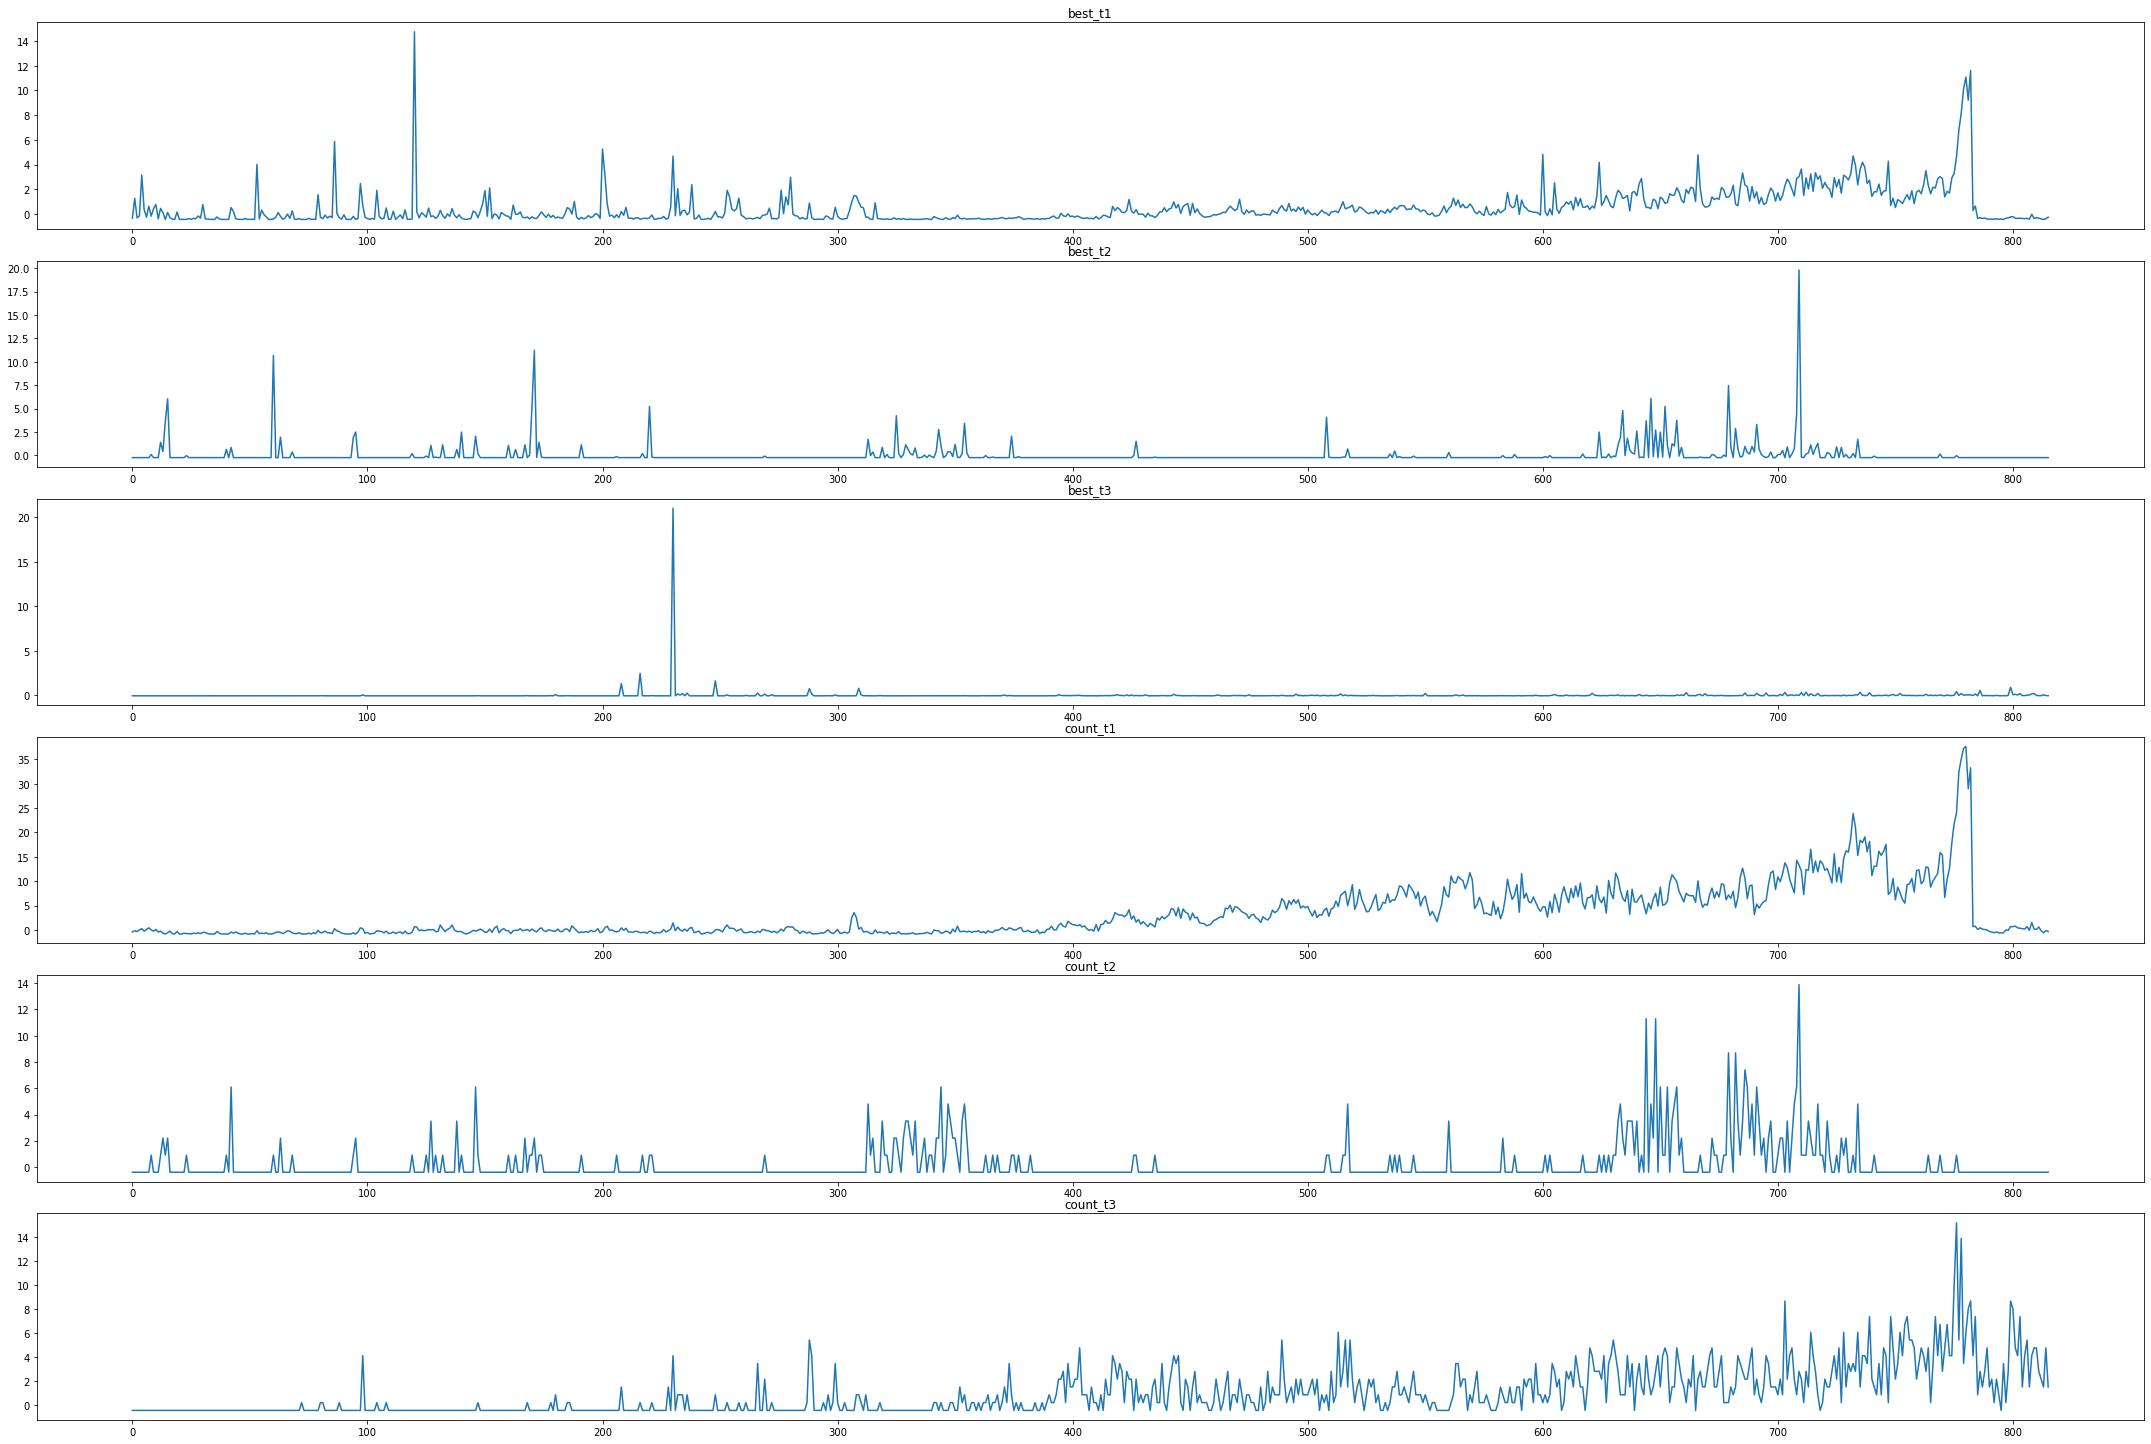

In [25]:
f, ax = plt.subplots(nrows=6, ncols=1, figsize=(30, 20))
f.tight_layout()
bests = ['best_t1', 'best_t2', 'best_t3', 'count_t1', 'count_t2', 'count_t3']
for i, f in enumerate(bests):
    sns.lineplot(x=afgh_data[f].index, y=afgh_data[f].values, ax=ax[i])
    ax[i].set_title(f)

<Figure size 432x288 with 0 Axes>

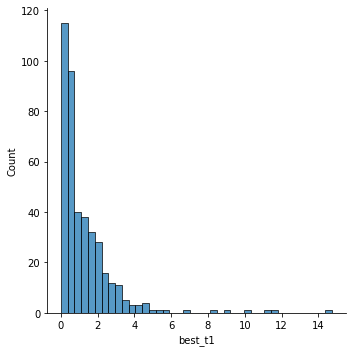

<Figure size 432x288 with 0 Axes>

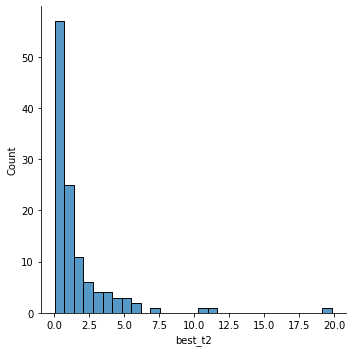

<Figure size 432x288 with 0 Axes>

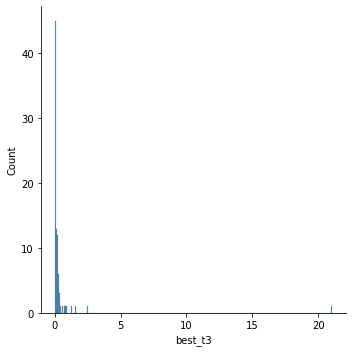

<Figure size 432x288 with 0 Axes>

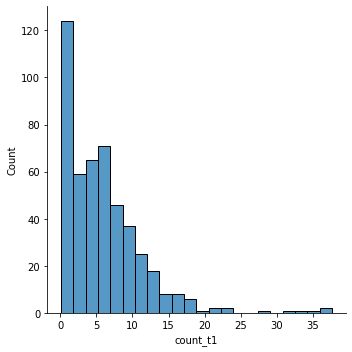

<Figure size 432x288 with 0 Axes>

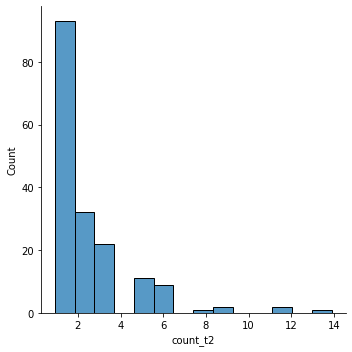

<Figure size 432x288 with 0 Axes>

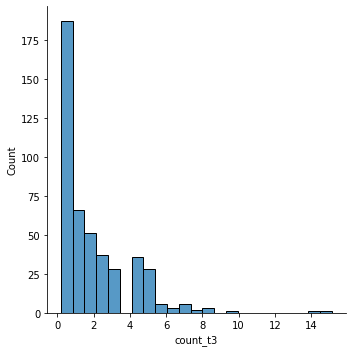

In [26]:
for i, f in enumerate(bests):
    plt.figure()
    sns.displot(x=afgh_data.loc[afgh_data[f] > 0, f], kind='hist')
    ax[i].set_title(f)

In [206]:
RANDOM_SEED = 1681
BATCH_SZ = 3
N_EPOCHS = 500
IN_TIMESTEPS = 100
OUT_TIMESTEPS = 1

import os
import tensorflow as tf
import random

random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [187]:
def make_dataset(ds: pd.DataFrame, y_column: str):
    X_data = ds[:-OUT_TIMESTEPS]
    # print(X_data)
    y_data = ds.loc[IN_TIMESTEPS:, y_column]
    
    X_data = np.array(X_data, dtype=np.float32)
    y_data = np.array(y_data, dtype=np.float32)
    
    tfds = tf.keras.utils.timeseries_dataset_from_array(
      data=X_data,
      targets=y_data,
      sequence_length=IN_TIMESTEPS,
      sequence_stride=1,
      shuffle=False,
      batch_size=BATCH_SZ)
    
    return tfds

In [207]:
batched_train = make_dataset(afgh_train, 'best_t1')
batched_val = make_dataset(afgh_val, 'best_t1')
batched_test = make_dataset(afgh_test, 'best_t1')

In [208]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(
        units=800,
        return_sequences=True
    ),
    tf.keras.layers.LSTM(
        units=600,
        return_sequences=True
    ),
    tf.keras.layers.LSTM(
        units=400,
        return_sequences=True
    ),
    tf.keras.layers.LSTM(
       units=300,
        return_sequences=True
    ),
    tf.keras.layers.LSTM(
       units=200,
        return_sequences=True
    ),
    tf.keras.layers.Dense(
        units=1,
        activation='linear'
    )
]) 

In [209]:
LOSS_FUNC = tf.keras.losses.MeanAbsoluteError()
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
METRICS =[tf.keras.metrics.MeanSquaredError()]

def build(model, train, val):
    model.compile(
        loss=LOSS_FUNC,
        metrics=METRICS,
        optimizer=OPTIMIZER
    )
    
    history = model.fit(train, epochs=N_EPOCHS, validation_data=val)
    
    return history

def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.figure(figsize=(12,4))
    sns.lineplot(x=range(0, len(loss)), y=loss)
    sns.lineplot(x=range(0, len(val_loss)), y=val_loss)

In [210]:
history = build(lstm_model, batched_train, batched_val)
plot_loss(history)

Epoch 1/500
 52/119 [============>.................] - ETA: 44s - loss: 0.5048 - mean_squared_error: 2.1558

KeyboardInterrupt: 